## Start Up

In [1]:
import io
import os
import os.path
import re
import matplotlib.pyplot as plt
import numpy as np
import cv2
import csv
import subprocess
import numpy as np
from PIL import Image
from io import BytesIO
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload
import torch
import torchvision

SCOPES = ['https://www.googleapis.com/auth/drive.file']
MIME_TYPE = 'application/vnd.google-apps.document'
APPLICATION_NAME = 'ipa-google-drive-api-client'

In [3]:
def get_service():

    # credentialの取得
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'google-drive-api.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
        
    # serviceの取得
    service = build('drive', 'v3', credentials=creds) 
    
    return service

def read_ocr(service, input_file, lang='jp'):
    # ファイルのアップロード

    # ローカルファイルの定義
    media_body = MediaFileUpload(input_file, mimetype=MIME_TYPE, resumable=True)

    # Google Drive上のファイル名
    newfile = 'output.pdf'

    body = {
        'name': newfile,
        'mimeType': MIME_TYPE
    }

    # 　creat関数でファイルアップロード実行
    # 同時にOCR読み取りも行う
    output = service.files().create(
        body=body,
        media_body=media_body,
        # ここで読み込み先言語の指定を行う
        ocrLanguage=lang,
    ).execute()

    # テキストファイルのダウンロード

    # リクエストオブジェクト生成
    request = service.files().export_media(
        fileId=output['id'],
        mimeType="text/plain"
    )
    output_path = 'output.txt'

    with open(output_path, 'a') as f:
        fh = io.FileIO(output_path, "wb")
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()

        service.files().delete(fileId=output['id']).execute()
    
        # テキストの取得
    with open(output_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # 読み取り結果のリストを返す
    return lines[1:]


service = get_service()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=177107319826-i8oj1jnq3najvtvm0prpb18ncuipamef.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A53430%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=duia8o0TkVvbkM3MOrFRcu0zdMHWT5&access_type=offline


In [4]:
def process_text_file(text_file):
    output_dir = "C:/Users/covid/text_recognition/output"
    if os.path.exists(output_dir):
        file_list = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
        for file_name in file_list:
            file_path = os.path.join(output_dir, file_name)
            os.remove(file_path)
    else:
        os.makedirs(output_dir)

    with open(text_file, 'r') as file:
        lines = file.readlines()

        lines = sorted(lines, key=lambda line: float(line.split()[1]))

        for i, line in enumerate(lines):
            line = line.strip()
            values = line.split()

            if len(values) >= 5:
                object_class = values[0]
                a = float(values[1])
                b = float(values[2])
                c = float(values[3])
                d = float(values[4])

                 # 信頼度スコアがある場合はスキップする
                if len(values) == 6:
                    confidence_score = float(values[5])  # 信頼度スコアを取得（必要なら保存せずにスキップ）
                
                # Calculate coordinates and dimensions
                x_center = int(wid * a)
                y_center = int(hei * b)
                width = int(wid * c)
                height = int(hei * d)

                x_min = x_center - width // 2
                y_min = y_center - height // 2
                x_max = x_center + width // 2
                y_max = y_center + height // 2

                output_filename = os.path.join(output_dir, f'book{i+1}.jpg')
                index = 1
                while os.path.exists(output_filename):
                    output_filename = os.path.join(output_dir, f'book{i+1}_{index}.jpg')
                    index += 1

                # Crop and save the image
                cropped = image.crop((x_min, y_min, x_max, y_max))
                cropped.save(output_filename)


In [34]:
import sys

# passの設定 (pip showで出てきた、LocationのPASSを以下に設定)
sys.path.append('c:/users/covid/anaconda3/lib/site-packages')

# passの設定はimportするモジュールより前に設定
import roboflow

In [35]:
#自身のモデル→versions→Export datasetにあるコードのコピペ
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9RdognCaI8Nuh4bFkYHc")
project = rf.workspace("koteitan").project("book-spine-detection-2cci9")
version = project.version(1)
dataset = version.download("yolov7")

ERROR: Could not install packages due to an OSError: [WinError 5] アクセスが拒否されました。: 'C:\\Users\\covid\\anaconda3\\envs\\localGPU\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



  Using cached roboflow-1.1.36-py3-none-any.whl.metadata (9.4 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached roboflow-1.1.36-py3-none-any.whl (76 kB)
Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to book-spine-detection-1 in yolov7pytorch:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7770/7770 [00:03<00:00, 2425.20it/s]


今回作成したモデルはなぜか書籍検知行われず、一方で作成したモデルの使用方法は判明したので今後はroboflow側でモデルのチューニングを行って書籍の検知および精度の向上を頑張る

In [36]:
#wgetの代用
import requests

url = 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt'
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open('yolov7_training.pt', 'wb') as f:
        f.write(response.content)
    print('File downloaded successfully')
else:
    print(f'Failed to download file. Status code: {response.status_code}')


File downloaded successfully


In [38]:
!python train.py --device 0 --batch 16 --epochs 55 --data data/coco.yaml --weights 'yolov7_training.pt'

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)


YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

Namespace(weights="'yolov7_training.pt'", cfg='', data='data/coco.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=55, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='exp', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs\\train\\exp2', total_batch_size=16)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias

In [98]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9RdognCaI8Nuh4bFkYHc")
project = rf.workspace("koteitan").project("book-spine-detection-2cci9")
version = project.version(1)
dataset = version.download("yolov8-obb")

ERROR: Could not install packages due to an OSError: [WinError 5] アクセスが拒否されました。: 'C:\\Users\\covid\\anaconda3\\envs\\localGPU\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



  Using cached roboflow-1.1.36-py3-none-any.whl.metadata (9.4 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached roboflow-1.1.36-py3-none-any.whl (76 kB)
Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
loading Roboflow workspace...
loading Roboflow project...


In [113]:
cd ..

C:\Users\covid\text_recognition


In [114]:
!pip install ultralytics

In [122]:
from ultralytics import YOLO
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
import yaml
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

In [126]:
!nvidia-smi

Thu Jul 25 18:31:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.92                 Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8              26W / 370W |   2256MiB / 24576MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [127]:
import os
HOME = os.getcwd()
print(HOME)

C:\Users\covid\text_recognition


In [128]:
!pip install ultralytics -q

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.64  Python-3.10.13 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
Setup complete  (8 CPUs, 31.9 GB RAM, 283.8/952.9 GB disk)


In [129]:
from ultralytics import YOLO

from IPython.display import display, Image

In [130]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("brad-dwyer").project("aerial-solar-panels")
dataset = project.version(6).download("yolov8-obb")

import yaml

with open(f'{dataset.location}/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data['path'] = dataset.location

with open(f'{dataset.location}/data.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)

[WinError 2] 指定されたファイルが見つかりません。: 'C:\\Users\\covid\\text_recognition/datasets'
C:\Users\covid\text_recognition


コマンドの構文が誤っています。


visit https://app.roboflow.com/auth-cli to get your authentication token.


Paste the authentication token here:  ········


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Aerial-Solar-Panels-6 in yolov8-obb:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:00<00:00, 2286.66it/s]


In [132]:
from ultralytics import YOLO

model = YOLO('yolov8n-obb.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

Ultralytics YOLOv8.2.64  Python-3.10.13 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
engine\trainer: task=obb, mode=train, model=yolov8n-obb.pt, data=C:\Users\covid\text_recognition\Aerial-Solar-Panels-6/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

AttributeError: module 'torch.amp' has no attribute 'GradScaler'

In [133]:
model = YOLO('runs/obb/train/weights/best.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

results = model(file_name)

print(results[0])

FileNotFoundError: [Errno 2] No such file or directory: 'runs\\obb\\train\\weights\\best.pt'

In [124]:
!pip install roboflow --user

from roboflow import Roboflow
rf = Roboflow(api_key="9RdognCaI8Nuh4bFkYHc")
project = rf.workspace("koteitan").project("book-spine-detection-2cci9")
version = project.version(1)
dataset = version.download("yolov8-obb")

  Using cached roboflow-1.1.36-py3-none-any.whl.metadata (9.4 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached roboflow-1.1.36-py3-none-any.whl (76 kB)
Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!yolo obb train data=/content/drive/MyDrive/AxrossRecipe/neji_obb/data.yaml pretrained=yolov8n-obb.pt epochs=100 imgsz=640 exist_ok=True

## Execution

In [165]:
cd ..

C:\Users\covid\text_recognition


###　シンプルな線文検知

[array([[  0,  59, 113, 551]], dtype=int32)]
[array([[  0,  59, 113, 551]], dtype=int32), array([[438,   2, 553, 503]], dtype=int32)]
[array([[  0,  59, 113, 551]], dtype=int32), array([[438,   2, 553, 503]], dtype=int32), array([[151, 333, 453, 269]], dtype=int32)]
[array([[  0,  59, 113, 551]], dtype=int32), array([[438,   2, 553, 503]], dtype=int32), array([[151, 333, 453, 269]], dtype=int32), array([[155, 334, 470, 267]], dtype=int32)]
[array([[  0,  59, 113, 551]], dtype=int32), array([[438,   2, 553, 503]], dtype=int32), array([[151, 333, 453, 269]], dtype=int32), array([[155, 334, 470, 267]], dtype=int32), array([[205, 465, 512, 389]], dtype=int32)]
[array([[  0,  59, 113, 551]], dtype=int32), array([[438,   2, 553, 503]], dtype=int32), array([[151, 333, 453, 269]], dtype=int32), array([[155, 334, 470, 267]], dtype=int32), array([[205, 465, 512, 389]], dtype=int32), array([[  0,  72, 111, 555]], dtype=int32)]
[array([[  0,  59, 113, 551]], dtype=int32), array([[438,   2, 553, 50

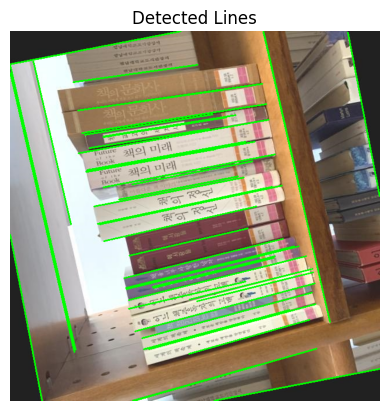

True

In [8]:
import math
def calculate_line_length(line):
    x1, y1, x2, y2 = line[0]
    length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return length

# 画像を読み込み
image = cv2.imread("result.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Cannyエッジ検出
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Hough変換による線分検出
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# 長さでフィルタリング
filtered_lines_by_length = []
for line in lines:  # 位置でフィルタリングした線に対して
    length = calculate_line_length(line)
    if length > 200:  # 長さが100ピクセル以上の線のみを残す
        filtered_lines_by_length.append(line)
        print(filtered_lines_by_length) 
        
# 検出された線分を画像に描画
if filtered_lines_by_length is not None:
    for line in filtered_lines_by_length:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 線分を緑色で描画

# 結果を表示
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines')
plt.axis('off')
plt.show()

# 結果を保存（必要に応じて）
cv2.imwrite("hough_lines_output.jpg", image)

###　↓今のところよさげなアイデア

Hough変換→最も長い線分の角度参照し回転  
この後文字認識または再度画像分割

最も長い線分の長さ: 514.0291820509805 ピクセル
最も長い線分の角度: 77.07221989927545 度


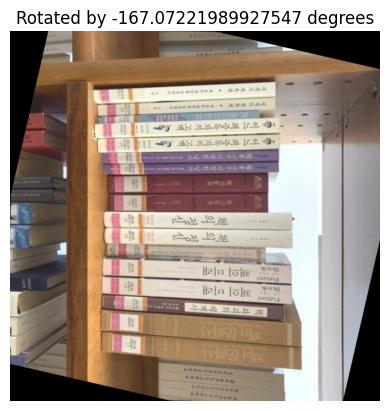

In [7]:
import math
# 線分の長さを計算する関数
def calculate_line_length(line):
    x1, y1, x2, y2 = line[0]
    length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return length

# 線分の角度を計算する関数
def calculate_angle(line):
    x1, y1, x2, y2 = line[0]
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))  # atan2で角度を計算
    return angle

# 画像を回転させる関数
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)  # マイナスの角度で反時計回りに回転
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated

# 画像を読み込み
image = cv2.imread("result.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Cannyエッジ検出
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Hough変換による線分検出
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# 長さでフィルタリング（200ピクセル以上の線のみを残す）
filtered_lines_by_length = [line for line in lines if calculate_line_length(line) > 200]

# 最も長い線分を探す
if len(filtered_lines_by_length) > 0:
    longest_line = max(filtered_lines_by_length, key=calculate_line_length)
    longest_line_length = calculate_line_length(longest_line)
    longest_line_angle = calculate_angle(longest_line)

    print(f"最も長い線分の長さ: {longest_line_length} ピクセル")
    print(f"最も長い線分の角度: {longest_line_angle} 度")
    longest_line_angle = longest_line_angle *-1 -90

    # 最も長い線分の角度で画像を回転
    rotated_image = rotate_image(image, longest_line_angle)

    # 回転後の画像を表示
    plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Rotated by {longest_line_angle} degrees')
    plt.axis('off')
    plt.show()

    # 結果を保存（必要に応じて）
    cv2.imwrite("rotated_output_by_longest_line.jpg", rotated_image)
else:
    print("200ピクセル以上の線分が見つかりませんでした。")
    # そのまま元の画像を表示
    plt.imshow(cv2)

### 画像45°回転手法

In [23]:
# 実行フロー
# image_path = capture_image("input.png")  # ステップ1: 画像を撮影

In [52]:
image_path = ("input.png")

In [25]:
# ステップ1: WEBカメラで画像を撮影して保存
def capture_image(output_path="input.png"):
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(output_path, frame)
        print(f"画像を撮影し、保存しました: {output_path}")
    else:
        print("画像の撮影に失敗しました。")
    cap.release()
    return output_path

In [68]:
print(directory_path)
print(image_path)

C:/Users/covid/text_recognition/yolov7/runs/detect
input.png


In [106]:
def get_absolute_path(relative_path):
    return os.path.abspath(relative_path)

# ステップ2: YOLOで物体検知を行い信頼度スコアを取得
def run_yolo(image_path, directory_path="runs/detect/"):
    image_path = get_absolute_path(image_path)  # 絶対パスに変換
    print(f"YOLOを実行中: {image_path}")
    
    !python detect.py --source {image_path} --weights yolov7x.pt --conf 0.85 --img-size 640 --device 0 --save-txt --save-conf --classes 73

    # 最新のサブディレクトリを取得
    subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    newest_subdirectory = max(subdirectories, key=lambda d: os.path.getctime(os.path.join(directory_path, d)))
    newest_subdirectory_path = os.path.join(directory_path, newest_subdirectory)
    
    # 検出されたバウンディングボックスのファイルを読み込む
    labels_dir = os.path.join(newest_subdirectory_path, "labels")
    label_file = os.path.join(labels_dir, os.path.basename(image_path).replace(".png", ".txt"))
    
    # スコアとバウンディングボックスを取得
    score = 0
    boxes = []
    
    if os.path.exists(label_file):
        with open(label_file, 'r') as file:
            lines = file.readlines()
            if lines:
                for line in lines:
                    data = line.strip().split()
                    class_id = int(data[0])
                    x_center, y_center, width, height, confidence = map(float, data[1:])
                    boxes.append((x_center, y_center, width, height))
                    score = confidence  # 信頼度スコアを更新
        #print(f"信頼度スコア: {score}")
    else:
        print(f"ラベルファイルが見つかりません: {label_file}")
    
    return score, boxes  # スコアとバウンディングボックスを返す

# バウンディングボックスを描画する関数
def draw_bounding_boxes(image, boxes):
    img_h, img_w = image.shape[:2]
    
    for box in boxes:
        x_center, y_center, width, height = box
        x1 = int((x_center - width / 2) * img_w)
        y1 = int((x_center - height / 2) * img_h)
        x2 = int((x_center + width / 2) * img_w)
        y2 = int((x_center + height / 2) * img_h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return image
    
# 画像を回転させる関数
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated

# ステップ3: 左右90度ずつの回転を各10度で行い物体検知を実行
def rotate_and_detect_full_image(image_path, rotation_step=10, output_dir="rotated_full_images"):
    image = cv2.imread(image_path)

    # 保存先のディレクトリを作成
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    scores = []

    for angle in range(-30, 31, rotation_step):  # -90度から90度まで10度刻みで回転
        rotated_image = rotate_image(image, angle)
        rotated_image_path = os.path.join(output_dir, f"full_image_rotated_{angle}.png")
        cv2.imwrite(rotated_image_path, rotated_image)
        #print(f"回転させた画像を保存しました: {rotated_image_path}")
        
         # YOLOを実行して検出
        score, boxes = run_yolo(rotated_image_path)

        # バウンディングボックスを描画
        rotated_image_with_boxes = draw_bounding_boxes(rotated_image, boxes)
        cv2.imwrite(rotated_image_path, rotated_image_with_boxes)  # バウンディングボックスを描画した画像を保存
        print(f"角度 {angle}度 の信頼度スコア: {score}")
        scores.append((angle, score))

    return scores

In [105]:
# 実行フロー
scores = rotate_and_detect_full_image(image_path)  # ステップ3: 全体画像の回転と物体検知を実施

print("全体画像の角度ごとの信頼度スコア:")
for angle, score in scores:
    print(f"角度 {angle}度: 信頼度スコア {score}")

YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_-30.png
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

ラベルファイルが見つかりません: runs/detect/exp\labels\full_image_rotated_-30.txt


YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


角度 -30度 の信頼度スコア: 0
YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_-20.png


YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

角度 -20度 の信頼度スコア: 0.901367
YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_-10.png
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


角度 -10度 の信頼度スコア: 0.937012
YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_0.png


YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

角度 0度 の信頼度スコア: 0.946289
YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_10.png


YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

角度 10度 の信頼度スコア: 0.905273
YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_20.png
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


角度 20度 の信頼度スコア: 0.88623
YOLOを実行中: C:\Users\covid\text_recognition\yolov7\rotated_full_images\full_image_rotated_30.png
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 354 layers, 71311741 parameters, 571965 gradients, 189.7 GFLOPS


角度 30度 の信頼度スコア: 0.896973
全体画像の角度ごとの信頼度スコア:
角度 -30度: 信頼度スコア 0
角度 -20度: 信頼度スコア 0.901367
角度 -10度: 信頼度スコア 0.937012
角度 0度: 信頼度スコア 0.946289
角度 10度: 信頼度スコア 0.905273
角度 20度: 信頼度スコア 0.88623
角度 30度: 信頼度スコア 0.896973


---------------

## 今迄のコード

In [23]:
#Variable list
# ディレクトリのパス
directory_path = "C:/Users/covid/text_recognition/yolov7/runs/detect"
# 画像ファイルの相対パスを指定
image_relative_path = "input.png"
# テキストファイルの相対パスを指定
text_file_relative_path = "labels/input.txt"

out_path = 'C:/Users/covid/text_recognition/output'
output_file = "C:/Users/covid/text_recognition/output_results.txt"

In [24]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()
cv2.imwrite("C:/Users/covid/text_recognition/yolov7/input.png",frame)

cap.release()

In [25]:
cd "C:\Users\covid\text_recognition\yolov7"

C:\Users\covid\text_recognition\yolov7


In [26]:
# ディレクトリ内のサブディレクトリのリストを取得
subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# サブディレクトリの中で一番新しいものを取得
newest_subdirectory = max(subdirectories, key=lambda d: os.path.getctime(os.path.join(directory_path, d)))

# 最新のサブディレクトリのパスを作成
newest_subdirectory_path = os.path.join(directory_path, newest_subdirectory)

In [27]:
!python detect.py --source C:/Users/covid/text_recognition/yolov7/input.png --weights yolov7-e6e.pt --conf 0.25 --img-size 1280 --device 0 --save-txt --save-conf
#本来なら学習した結果重みが新しく生成されるはずでは？？次回調査する

 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



YOLOR  v0.1-126-g84932d7 torch 2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)

C:\Users\covid\anaconda3\envs\localGPU\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 792 layers, 151687420 parameters, 817020 gradients, 210.5 GFLOPS


In [28]:
# ディレクトリ内のサブディレクトリのリストを取得
subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# サブディレクトリの中で一番新しいものを取得
newest_subdirectory = max(subdirectories, key=lambda d: os.path.getctime(os.path.join(directory_path, d)))

# 最新のサブディレクトリのパスを作成
newest_subdirectory_path = os.path.join(directory_path, newest_subdirectory)
# 新しいディレクトリに移動
os.chdir(newest_subdirectory_path)

# 画像ファイルの絶対パスを作成
image_absolute_path = os.path.join(newest_subdirectory_path, image_relative_path)
# テキストファイルの絶対パスを作成
text_file_absolute_path = os.path.join(newest_subdirectory_path, text_file_relative_path)

In [29]:
# 画像をImageクラスのインスタンスに読み込む
image = Image.open(image_absolute_path)
# テキストファイルを読み込む
with open(text_file_absolute_path, 'r') as file:
    text_content = file.read()

In [30]:
print(text_content)

73 0.935156 0.532812 0.129688 0.071875 0.254395
62 0.90625 0.369531 0.1875 0.276563 0.268799
73 0.464063 0.397656 0.515625 0.110937 0.309814
73 0.857813 0.146875 0.159375 0.15 0.356445
73 0.879687 0.233594 0.159375 0.0890625 0.371826
73 0.553125 0.648438 0.48125 0.146875 0.477051
73 0.94375 0.654688 0.1125 0.05625 0.484619
73 0.48125 0.486719 0.515625 0.154687 0.504395
73 0.43125 0.264062 0.546875 0.11875 0.523438
73 0.453125 0.314063 0.525 0.140625 0.529297
73 0.934375 0.597656 0.13125 0.0828125 0.542969
73 0.530469 0.534375 0.445312 0.14375 0.588379
73 0.599219 0.819531 0.495313 0.173438 0.606445
73 0.570312 0.723437 0.50625 0.175 0.609375
73 0.535937 0.586719 0.446875 0.142188 0.62207
73 0.416406 0.214062 0.560938 0.146875 0.628418
73 0.407813 0.153125 0.55625 0.134375 0.734375



In [31]:
# Process the text file
wid,hei = image.size
process_text_file(text_file_absolute_path)

In [13]:
#output corresponding to list format
if __name__ == '__main__':
    output_list = []

    file_list = [filename for filename in os.listdir(out_path) if filename.endswith('.jpg')]
    file_list.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    for filename in file_list:
        input_file = os.path.join(out_path, filename)
        output = read_ocr(service, input_file, 'ja')

        # 不要な文字（スペースとバックスラッシュ）を除去して一つの文字列に結合する
        cleaned_output = ''.join(line.strip().replace(' ', '').replace('/', '').replace('\n', '').replace('\\', '') for line in output)

        # 結果をリストに追加
        output_list.append(cleaned_output)

In [14]:
# Save the results to the output file
with open(output_file, 'w', encoding='utf-8') as file:
        for result in output_list:
            file.write(result + '\n')

print(f"Results saved to {output_file}")

Results saved to C:/Users/covid/text_recognition/output_results.txt


## Compare NLP Methods

### Different.SequenceMatcher

In [15]:
cd "C:\\Users\\covid\\text_recognition"

C:\Users\covid\text_recognition


In [16]:
import difflib

def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    for index_a, text_a in enumerate(lines_a):
        max_similarity = 0.0
        best_match = None
        best_match_text_b = None

        for index_b, text_b in enumerate(lines_b):
            similarity = difflib.SequenceMatcher(None, text_a, text_b).ratio()

            if similarity > max_similarity:
                max_similarity = similarity
                best_match = text_b
                best_match_text_b = text_b

        print(f"Text A (line {index_a + 1}): {text_a.strip()}")
        print(f"Best Match in Text B (line {lines_b.index(best_match) + 1}): {best_match.strip()}")
        print(f"Highest Similarity Ratio: {max_similarity:.4f}\n")

if __name__ == "__main__":
    main()


Text A (line 1): つための行列代DONG
Best Match in Text B (line 19): 大学編入のための数学問題集
Highest Similarity Ratio: 0.3077

Text A (line 2): つための石川DONEDON
Best Match in Text B (line 19): 大学編入のための数学問題集
Highest Similarity Ratio: 0.2857

Text A (line 3): ematics
Best Match in Text B (line 117): 新応用数学AppliedMathematics大日本図書
Highest Similarity Ratio: 0.4324

Text A (line 4): 
Best Match in Text B (line 129): 合格平成29年度
Highest Similarity Ratio: 0.2000



In [92]:
def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"
    output_file = "output_similarity.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    with open(output_file, "w", encoding="utf-8") as output:
        for index_a, text_a in enumerate(lines_a):
            for index_b, text_b in enumerate(lines_b):
                similarity = difflib.SequenceMatcher(None, text_a, text_b).ratio()

                output.write(f"Text A (line {index_a + 1}): {text_a.strip()}\n")
                output.write(f"Text B (line {index_b + 1}): {text_b.strip()}\n")
                output.write(f"Similarity Ratio: {similarity:.4f}\n\n")

if __name__ == "__main__":
    main()


### Levenshtein distance

In [78]:
import Levenshtein

def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    for index_a, text_a in enumerate(lines_a):
        max_similarity = 0.0
        best_match = None

        for index_b, text_b in enumerate(lines_b):
            similarity = Levenshtein.ratio(text_a.strip(), text_b.strip())

            if similarity > max_similarity:
                max_similarity = similarity
                best_match = text_b

        print(f"Original Text A (line {index_a + 1}): {text_a.strip()}")
        print(f"Best Match for Text A (line {index_a + 1}): {best_match.strip()}")
        print(f"Highest Similarity Ratio: {max_similarity:.4f}\n")

if __name__ == "__main__":
    main()

Original Text A (line 1): ポイント代キーポイント散キーポイント統計のための行列代数四ツ谷伊
Best Match for Text A (line 1): キーポイント線形代数薩摩順吉四ツ谷昌二岩波書店
Highest Similarity Ratio: 0.4000

Original Text A (line 2): 新応用数学Applied微分積分IIRHDifferentialIntegralシト線形代数AlgerIntegral1四ツ谷二
Best Match for Text A (line 2): 新微分積分IDifferentialANDIntegralI大日本図書
Highest Similarity Ratio: 0.5455

Original Text A (line 3): 基礎数学FundamentalMathematics.新応用数学Appliedhematica微分積分IntegralTRHDifferentialintegralポイント代四ツ谷キーポイントポイント四ツ谷二統計のための行列代数リバーヴィル伊KIDWES
Best Match for Text A (line 3): 新基礎数学FundamentalMathematics大日本図書
Highest Similarity Ratio: 0.3270

Original Text A (line 4): 基礎数学FundamentalMathematics.Appliedematics,
Best Match for Text A (line 4): 新基礎数学FundamentalMathematics大日本図書
Highest Similarity Ratio: 0.7027

Original Text A (line 5): 


AttributeError: 'NoneType' object has no attribute 'strip'

In [ ]:
def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"
    output_file = "levenshtein_similarity.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    with open(output_file, "w", encoding="utf-8") as output:
        for index_a, text_a in enumerate(lines_a):
            max_similarity = 0.0
            best_match = None

            for index_b, text_b in enumerate(lines_b):
                similarity = Levenshtein.ratio(text_a.strip(), text_b.strip())

                output.write(f"Text A (line {index_a + 1}): {text_a.strip()}\n")
                output.write(f"Text B (line {index_b + 1}): {text_b.strip()}\n")
                output.write(f"Similarity Ratio: {similarity:.4f}\n\n")

                if similarity > max_similarity:
                    max_similarity = similarity
                    best_match = text_b

            output.write(f"Best Match for Text A (line {index_a + 1}): {best_match.strip()}\n")
            output.write(f"Highest Similarity Ratio: {max_similarity:.4f}\n\n")

if __name__ == "__main__":
    main()


### Jaccard

In [ ]:
def jaccard_coefficient(s1, s2):
    set1 = set(s1)
    set2 = set(s2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    for index_a, text_a in enumerate(lines_a):
        max_similarity = 0.0
        best_match = None

        for index_b, text_b in enumerate(lines_b):
            similarity = jaccard_coefficient(text_a.strip(), text_b.strip())

            if similarity > max_similarity:
                max_similarity = similarity
                best_match = text_b

        print(f"Original Text A (line {index_a + 1}): {text_a.strip()}")
        print(f"Best Match for Text A (line {index_a + 1}): {best_match.strip()}")
        print(f"Highest Jaccard Coefficient: {max_similarity:.4f}\n")

if __name__ == "__main__":
    main()


In [ ]:
def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"
    output_file = "jaccard_similarity.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    with open(output_file, "w", encoding="utf-8") as output:
        for index_a, text_a in enumerate(lines_a):
            for index_b, text_b in enumerate(lines_b):
                similarity = jaccard_coefficient(text_a.strip(), text_b.strip())

                output.write(f"Text A (line {index_a + 1}): {text_a.strip()}\n")
                output.write(f"Text B (line {index_b + 1}): {text_b.strip()}\n")
                output.write(f"Jaccard Coefficient: {similarity:.4f}\n\n")

if __name__ == "__main__":
    main()


In [ ]:
def jaccard_coefficient(s1, s2):
    set1 = set(s1)
    set2 = set(s2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def main():
    file_a_path = "output_results.txt"
    file_b_path = "database.txt"

    with open(file_a_path, "r", encoding="utf-8") as file_a:
        lines_a = file_a.readlines()

    with open(file_b_path, "r", encoding="utf-8") as file_b:
        lines_b = file_b.readlines()

    for index_a, text_a in enumerate(lines_a):
        # 空白の行をスキップ
        if not text_a.strip():
            continue

        max_similarity = 0.0
        best_match = None

        for index_b, text_b in enumerate(lines_b):
            similarity = jaccard_coefficient(text_a.strip(), text_b.strip())

            if similarity > max_similarity:
                max_similarity = similarity
                best_match = text_b

        print(f"Original Text A (line {index_a + 1}): {text_a.strip()}")
        
        if best_match is not None:
            print(f"Best Match for Text A (line {index_a + 1}): {best_match.strip()}")
            print(f"Highest Jaccard Coefficient: {max_similarity:.4f}\n")
        else:
            print("No matching text found.\n")

if __name__ == "__main__":
    main()


In [194]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


In [193]:
%%bash
nvidia-smi

  i n u x   (u  W i n d o w s   �0�0�0�0�0�0k0o00�0�0�0�0�0�0�0�0�0�0�0L0�0�0�0�0�0�0U0�0f0D0~0[0�00
 �0�0�0�0�0�0�0�0�0�0�0o0  M i c r o s o f t   S t o r e   k0�0�0�0�0W0f0�0�0�0�0�0�0Y0�0S0h0L0g0M0~0Y0: 
 h t t p s : / / a k a . m s / w s l s t o r e 
 

CalledProcessError: Command 'b'nvidia-smi\n'' returned non-zero exit status 1.